# Data Keepers

mongodb ui: localhost:27017/

spark ui: localhost:4040/

### Problem

* Given a country X, provide a list of airports operating in country X.
* Given a number of stops X, provide a list of airlines having X stops.
* Given a code share X for airlines, provide a list of airlines operating with code share X.
* Given the option to display active airlines, provide a list of active airlines if selected.
* Given the option to display the country or territory with the highest number of airports, provide the country or territory with the highest number of airports if selected.
* Given a number of cities X, provide the top X cities with the most incoming and outgoing airlines.
* Given two cities X and Y, provide a list of routes connecting cities X and Y.
* Given two cities X and Y and a number of stops Z, provide a list of routes connecting cities X and Y with less than Z stops.
* Given a city X and number of stops Y, provide a list of cities that can be reached from X within Y stops.
* Given all routes, provide the transitive closure of the graph of all routes.



## Load library

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import set_matplotlib_formats
import warnings

## Check Python version

In [3]:
import geopandas as gpd

In [4]:
print(pyspark.__version__)

3.3.0


## Build pyspark session

In [5]:
spark = SparkSession.builder\
.appName('DataKeepers')\
.master('local')\
.config('spark.mongodb.input.uri', 'mongodb://127.0.0.1:27017/Aiport')\
.config('spark.mongodb.output.uri', 'mongodb://127.0.0.1:27017/Airport')\
.config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1')\
.getOrCreate()


22/10/13 21:48:55 WARN Utils: Your hostname, NamJunui-MacBookPro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.12 instead (on interface en0)
22/10/13 21:48:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/opt/homebrew/Caskroom/miniforge/base/envs/pythonProject1/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/namjunlee/.ivy2/cache
The jars for the packages stored in: /Users/namjunlee/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-526a670e-7764-48da-8efe-57e14287bc91;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 327ms :: artifacts dl 21ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   a

22/10/13 21:48:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Loading all collections

In [6]:
start = time.time()
airports = spark.read\
    .format('com.mongodb.spark.sql.DefaultSource')\
    .option( "uri", "mongodb://127.0.0.1:27017/Airport.airports") \
    .load()

In [7]:
airlines = spark.read\
    .format('com.mongodb.spark.sql.DefaultSource')\
    .option( "uri", "mongodb://127.0.0.1:27017/Airport.airlines") \
    .load()

In [8]:
countries = spark.read\
    .format('com.mongodb.spark.sql.DefaultSource')\
    .option( "uri", "mongodb://127.0.0.1:27017/Airport.countries") \
    .load()

In [9]:
planes = spark.read\
    .format('com.mongodb.spark.sql.DefaultSource')\
    .option( "uri", "mongodb://127.0.0.1:27017/Airport.planes") \
    .load()

In [10]:
routes = spark.read\
    .format('com.mongodb.spark.sql.DefaultSource')\
    .option( "uri", "mongodb://127.0.0.1:27017/Airport.routes") \
    .load()
print("Loading time: ", time.time() - start)

Loading time:  6.825713872909546


## Check schema

In [11]:
airports.printSchema()

root
 |-- AirportID: integer (nullable = true)
 |-- Altitude: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- DST: string (nullable = true)
 |-- IATA: string (nullable = true)
 |-- ICAO: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Name: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Timezone: double (nullable = true)
 |-- Type: string (nullable = true)
 |-- TzDatabase: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



In [12]:
airlines.printSchema()

root
 |-- Active: string (nullable = true)
 |-- AirlineID: integer (nullable = true)
 |-- Alias: string (nullable = true)
 |-- Callsign: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- IATA: string (nullable = true)
 |-- ICAO: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



In [13]:
countries.printSchema()

root
 |-- DAFIF: string (nullable = true)
 |-- ISO: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



In [14]:
planes.printSchema()

root
 |-- IATA: string (nullable = true)
 |-- ICAO: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



In [15]:
routes.printSchema()

root
 |-- Airline: string (nullable = true)
 |-- AirlineID: double (nullable = true)
 |-- Codeshare: string (nullable = true)
 |-- DestinationAirport: string (nullable = true)
 |-- DestinationAirportID: double (nullable = true)
 |-- Equipment: string (nullable = true)
 |-- SourceAirport: string (nullable = true)
 |-- SourceAirportID: double (nullable = true)
 |-- Stops: integer (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



## Check NULL & Cleaning

In [16]:
from pyspark.sql.functions import col, isnan, when, count, isnull

### Check NULL

In [17]:
airlines.select([count(when(isnull(c), c)).alias(c) for c in airlines.columns]).show()
airports.select([count(when(isnull(c), c)).alias(c) for c in airports.columns]).show()
routes.select([count(when(isnull(c), c)).alias(c) for c in routes.columns]).show()
countries.select([count(when(isnull(c), c)).alias(c) for c in countries.columns]).show()
planes.select([count(when(isnull(c), c)).alias(c) for c in planes.columns]).show()


+------+---------+-----+--------+-------+----+----+----+---+
|Active|AirlineID|Alias|Callsign|Country|IATA|ICAO|Name|_id|
+------+---------+-----+--------+-------+----+----+----+---+
|     0|        0|    0|       0|      0|   0|   0|   0|  0|
+------+---------+-----+--------+-------+----+----+----+---+



+---------+--------+----+-------+---+----+----+--------+---------+----+------+--------+----+----------+---+
|AirportID|Altitude|City|Country|DST|IATA|ICAO|Latitude|Longitude|Name|Source|Timezone|Type|TzDatabase|_id|
+---------+--------+----+-------+---+----+----+--------+---------+----+------+--------+----+----------+---+
|        0|       0|   0|      0|  0|   0|   0|       0|        0|   0|     0|       0|   0|         0|  0|
+---------+--------+----+-------+---+----+----+--------+---------+----+------+--------+----+----------+---+



+-------+---------+---------+------------------+--------------------+---------+-------------+---------------+-----+---+
|Airline|AirlineID|Codeshare|DestinationAirport|DestinationAirportID|Equipment|SourceAirport|SourceAirportID|Stops|_id|
+-------+---------+---------+------------------+--------------------+---------+-------------+---------------+-----+---+
|      0|        0|    53066|                 0|                   0|       18|            0|              0|    0|  0|
+-------+---------+---------+------------------+--------------------+---------+-------------+---------------+-----+---+

+-----+---+----+---+
|DAFIF|ISO|Name|_id|
+-----+---+----+---+
|    0|  0|   0|  0|
+-----+---+----+---+

+----+----+----+---+
|IATA|ICAO|Name|_id|
+----+----+----+---+
|   0|   0|   0|  0|
+----+----+----+---+



Above the dataframe, it shows that only routes collection have NULL values. But there are collections where missing values are set in different special languages, so we plan to change all missing values to the same values. ex: "-", "\\N", "", "NaN" -> "N/A"
And also, remove the unnecessary columns we solve the our problems.

### Data Preprocessing

##### airports

In [18]:
# airports 
cols_airports = ("Altitude", "Source", "Timezone", "Type", "TzDatabase", "DST")
# drop column
airports1 = airports.drop(*cols_airports)
# fill NULL
airports1 = airports1.fillna("N/A")
airports1 = airports1.na.replace("-", "N/A")
airports1 = airports1.na.replace("\\N", "N/A")
airports1 = airports1.na.replace("NaN", "N/A")
airports1 = airports1.na.replace("", "N/A")

In [19]:
# recheck the schema
airports1.printSchema()

root
 |-- AirportID: integer (nullable = true)
 |-- City: string (nullable = false)
 |-- Country: string (nullable = false)
 |-- IATA: string (nullable = false)
 |-- ICAO: string (nullable = false)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Name: string (nullable = false)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



##### airlines

In [25]:
# airlines
cols_airlines = ("Alias") # so many empty space
# drop column
airlines1 = airlines.drop(cols_airlines)
# fill NULL
airlines1 = airlines1.fillna("N/A")
airlines1 = airlines1.na.replace("-", "N/A")
airlines1 = airlines1.na.replace("\\N", "N/A")
airlines1 = airlines1.na.replace("NaN", "N/A")
airlines1 = airlines1.na.replace("", "N/A")
airlines1 = airlines1.na.replace("Unknown", "N/A")
# drop first row (airlineID = -1)
airlines1 = airlines1.where(airlines1.AirlineID > -1)

In [26]:
# recheck the schema
airlines1.printSchema()

root
 |-- Active: string (nullable = false)
 |-- AirlineID: integer (nullable = true)
 |-- Callsign: string (nullable = false)
 |-- Country: string (nullable = false)
 |-- IATA: string (nullable = false)
 |-- ICAO: string (nullable = false)
 |-- Name: string (nullable = false)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



##### planes

In [27]:
# fill NULL
planes1 = planes.fillna("N/A")
planes1 = planes1.na.replace("-", "N/A")
planes1 = planes1.na.replace("\\N", "N/A")
planes1 = planes1.na.replace("NaN", "N/A")
planes1 = planes1.na.replace("", "N/A")

##### countries

In [28]:
# fill NULL
countries1 = countries.fillna("N/A")
countries1 = countries1.na.replace("-", "N/A")
countries1 = countries1.na.replace("\\N", "N/A")
countries1 = countries1.na.replace("NaN", "N/A")
countries1 = countries1.na.replace("", "N/A")

##### routes

In [29]:
# drop column
cols_routes = ("Equipment") 
routes1 = routes.drop(cols_routes)
# fill NULL
routes1 = routes1.fillna("N/A")
routes1 = routes1.na.replace("-", "N/A")
routes1 = routes1.na.replace("\\N", "N/A")
routes1 = routes1.na.replace("NaN", "N/A")
routes1 = routes1.na.replace("", "N/A")
# change the value in Codeshare ("N/A" to N else Y)
routes1 = routes1.replace("N/A","N", ["Codeshare"])

In [30]:
# recheck the schema of routes
routes1.printSchema()

root
 |-- Airline: string (nullable = false)
 |-- AirlineID: double (nullable = true)
 |-- Codeshare: string (nullable = false)
 |-- DestinationAirport: string (nullable = false)
 |-- DestinationAirportID: double (nullable = true)
 |-- SourceAirport: string (nullable = false)
 |-- SourceAirportID: double (nullable = true)
 |-- Stops: integer (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



In [31]:
# recheck the null of routes
routes1.select([count(when(isnull(c), c)).alias(c) for c in routes1.columns]).show()

+-------+---------+---------+------------------+--------------------+-------------+---------------+-----+---+
|Airline|AirlineID|Codeshare|DestinationAirport|DestinationAirportID|SourceAirport|SourceAirportID|Stops|_id|
+-------+---------+---------+------------------+--------------------+-------------+---------------+-----+---+
|      0|        0|        0|                 0|                   0|            0|              0|    0|  0|
+-------+---------+---------+------------------+--------------------+-------------+---------------+-----+---+



## Build Temp 

In [32]:
# prepare using SQL
aiport_table = airports1.createOrReplaceTempView("airports1")
airline_table = airlines1.createOrReplaceTempView("airlines1")
country_table = countries1.createOrReplaceTempView("countries1")
plane_table = planes1.createOrReplaceTempView("planes1")
routes_table = routes1.createOrReplaceTempView("routes1")

## Problems 

### Problem 1
#### Given a country X, provide a list of airports operating in country X.

In [33]:
find1 = input("Enter country: ")
# check execution time
start = time.time()
first = spark.sql(f"SELECT AirportID, Name, City, Country \
    FROM airports1")
p1 = first.filter(first.Country.like(f"{find1}")) 
p1.show()
print("execution time: ", time.time() - start) 


Enter country: Iceland
+---------+--------------------+--------------+-------+
|AirportID|                Name|          City|Country|
+---------+--------------------+--------------+-------+
|       11|    Akureyri Airport|      Akureyri|Iceland|
|       12| Egilsstaðir Airport|   Egilsstadir|Iceland|
|       13|Hornafjörður Airport|          Hofn|Iceland|
|       14|     Húsavík Airport|       Husavik|Iceland|
|       15|  Ísafjörður Airport|    Isafjordur|Iceland|
|       16|Keflavik Internat...|      Keflavik|Iceland|
|       17|Patreksfjörður Ai...|Patreksfjordur|Iceland|
|       18|   Reykjavik Airport|     Reykjavik|Iceland|
|       19|Siglufjörður Airport|  Siglufjordur|Iceland|
|       20|Vestmannaeyjar Ai...|Vestmannaeyjar|Iceland|
|     4321|       Bakki Airport|         Bakki|Iceland|
|     5450|     Grímsey Airport|       Grímsey|Iceland|
|     5452|   Thorshofn Airport|     Thorshofn|Iceland|
|     5453|Vopnafjörður Airport|  Vopnafjörður|Iceland|
|     6867|  Reykjahlíð A

### Problem 2
#### Given a number of stops X, provide a list of airlines having X stops.

In [34]:
find2 = input("Enter num of stop: ")
# check execution time
start = time.time()
second = spark.sql(f"SELECT DISTINCT airlines1.AirlineID, \
    Name, Stops FROM airlines1, routes1 \
    WHERE airlines1.AirlineID = routes1.AirlineID\
    ORDER BY airlines1.AirlineID")
p2 = second.filter(second.Stops.like(f"{find2}"))
p2.show()
print("execution time: ", time.time() - start) 


Enter num of stop: 1


+---------+--------------------+-----+
|AirlineID|                Name|Stops|
+---------+--------------------+-----+
|      330|          Air Canada|    1|
|     1316|     AirTran Airways|    1|
|     1623|      Canadian North|    1|
|     1936|  Cubana de Aviación|    1|
|     4319|Scandinavian Airl...|    1|
|     4547|  Southwest Airlines|    1|
+---------+--------------------+-----+

execution time:  2.6784818172454834


### Problem 3
#### Given a code share X for airlines, provide a list of airlines operating with code share X.

doing:  
output: airlines1.AirlineID, Name, Country, Codeshare  
routes1: Codeshare (Given), AirlineID (join)  
airlines1: AirlineID (join), Name, Country

In [35]:
find3 = input("Enter Codeshare (Y or N): ")
# check execution time
start = time.time()
third = spark.sql(f"SELECT DISTINCT airlines1.AirlineID, Name, Country, Codeshare\
    FROM airlines1, routes1\
    WHERE airlines1.AirlineID = routes1.AirlineID\
    ORDER BY airlines1.AirlineID") 
p3 = third.filter(third.Codeshare.like(f"{find3}"))
p3.show()
print("execution time: ", time.time() - start) 



Enter Codeshare (Y or N): Y


+---------+--------------------+-----------------+---------+
|AirlineID|                Name|          Country|Codeshare|
+---------+--------------------+-----------------+---------+
|       24|   American Airlines|    United States|        Y|
|       28|     Asiana Airlines|Republic of Korea|        Y|
|       90|          Air Europa|            Spain|        Y|
|       96|     Aegean Airlines|           Greece|        Y|
|      116|           Air Italy|            Italy|        Y|
|      130|Aeroflot Russian ...|           Russia|        Y|
|      137|          Air France|           France|        Y|
|      197| Azerbaijan Airlines|       Azerbaijan|        Y|
|      214|          Air Berlin|          Germany|        Y|
|      218|   Air India Limited|            India|        Y|
|      225|      Air Tahiti Nui|           France|        Y|
|      240|             Air One|            Italy|        Y|
|      241|          Air Sahara|            India|        Y|
|      242|           Ai

### Problem 4
#### Given the option to display active airlines, provide a list of active airlines if selected.

doing:   
output: airlines1.AirlineID, Name, Country, Active  
airlines1: AirlineID, Name, Country, Active

In [36]:
find4 = input("Enter active (Y or N): ")
# check execution time
start = time.time()
fourth = spark.sql(f"SELECT AirlineID, Name, Country, Active\
    FROM airlines1\
    ORDER BY AirlineID") 
p4 = fourth.filter(fourth.Active.like(f"{find4}"))
p4.show()
print("execution time: ", time.time() - start) 



Enter active (Y or N): Y
+---------+--------------------+--------------------+------+
|AirlineID|                Name|             Country|Active|
+---------+--------------------+--------------------+------+
|        1|      Private flight|                 N/A|     Y|
|        3|       1Time Airline|        South Africa|     Y|
|       10|         40-Mile Air|       United States|     Y|
|       13|    Ansett Australia|           Australia|     Y|
|       14|Abacus International|           Singapore|     Y|
|       21|          Aigle Azur|              France|     Y|
|       22|      Aloha Airlines|       United States|     Y|
|       24|   American Airlines|       United States|     Y|
|       28|     Asiana Airlines|   Republic of Korea|     Y|
|       29|     Askari Aviation|            Pakistan|     Y|
|       32|   Afriqiyah Airways|               Libya|     Y|
|       35|       Allegiant Air|       United States|     Y|
|       42|ABSA - Aerolinhas...|              Brazil|     Y|

### Problem 5
#### Given the option to display the country or territory with the highest number of airports, provide the country or territory with the highest number of airports if selected.

doing:  
Given: Country or territory  
input:   
airports1: airports1.Country (join), airports1.AirportID, airports1.Name  
airlines1: airlines1.Country (join)  
countries1: name (join)  
output:  
Country (airports) , COUNT(airportName (airports)) * Highest 10

In [37]:
# check execution time
start = time.time()
fifth = spark.sql(f"SELECT airports1.Country, COUNT(airportID) as Result\
    FROM airports1, countries1\
    WHERE airports1.Country = countries1.name\
    GROUP BY airports1.Country\
    HAVING COUNT(airportID)\
    ORDER BY Result DESC\
    LIMIT 10") 
fifth.show()
print("execution time: ", time.time() - start) 



+--------------+------+
|       Country|Result|
+--------------+------+
| United States|  1512|
|        Canada|   430|
|     Australia|   334|
|         India|   296|
|        Russia|   264|
|        Brazil|   264|
|       Germany|   249|
|         China|   241|
|        France|   217|
|United Kingdom|   167|
+--------------+------+

execution time:  1.463404893875122


In [38]:
# given country and find the highest num (top10) of airports in each cities
find5 = input("Enter Country: ")
# check execution time
start = time.time()
fifth1 = spark.sql(f"SELECT airports1.City, COUNT(airportID) as Result\
    FROM airports1, countries1\
    WHERE airports1.Country = countries1.name AND airports1.Country LIKE '{find5}'\
    GROUP BY airports1.City\
    HAVING COUNT(airportID)\
    ORDER BY Result DESC\
    LIMIT 10")
fifth1.show()
print("execution time: ", time.time() - start)
# convert pandas dataframe
fifth1_df = fifth1.toPandas()

Enter Country: Canada
+---------+------+
|     City|Result|
+---------+------+
|Vancouver|     5|
|  Toronto|     4|
|   Ottawa|     3|
| Victoria|     3|
| Montreal|     3|
|   Kenora|     2|
|Deer Lake|     2|
|  Nanaimo|     2|
| Edmonton|     2|
|Lutselk'e|     2|
+---------+------+

execution time:  1.781637191772461


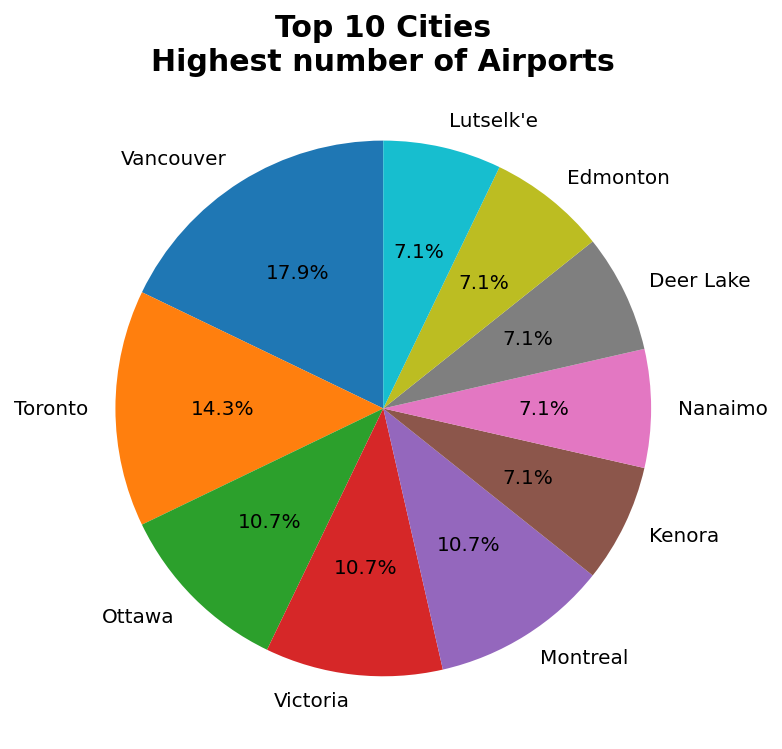

In [39]:
# visualize
warnings.filterwarnings(action='ignore')
fig = plt.figure(figsize=(6,6))
plt.axis('equal')
set_matplotlib_formats('retina')
plt.pie(fifth1_df['Result'], labels=fifth1_df['City'],
       startangle=90, autopct='%1.1f%%')
plt.title("Top 10 Cities\nHighest number of Airports", fontsize=15, fontweight='bold')
plt.show()

### Problem 6
#### Given a number of cities X, provide the top X cities with the most incoming and outgoing airlines.

Given:  
airports1(City) 

input:  
countries1(name)  
airlines1(AirlineID, Name, Country)
       airports1(Name,City,Country,AirportID)  
       routes1(AirlineID, DestinationAirportID,SourceAirportID)  
       
output: Country, City, Result


In [40]:
find6_0 = input("Enter num of cities: ")
# check execution time
start = time.time()
## incoming
sixth1_0 = spark.sql(f"SELECT airports1.City, COUNT(routes1.AirlineID) as incoming \
    FROM routes1, airlines1, countries1, airports1 \
    WHERE countries1.Name = airports1.Country AND \
    routes1.DestinationAirportID = airports1.AirportID AND \
    airlines1.AirlineID = routes1.AirlineID \
    GROUP BY airports1.City \
    ORDER BY incoming DESC \
    LIMIT {find6_0}")
sixth1_0.show()
print("execution time: ", time.time() - start)
sixth1_0.createOrReplaceTempView("sixth1_0")

# check execution time
start = time.time()
## outgoing
sixth2_0 = spark.sql(f"SELECT airports1.City, COUNT(routes1.AirlineID) as outgoing \
    FROM routes1, airlines1, countries1, airports1 \
    WHERE countries1.Name = airports1.Country AND \
    routes1.SourceAirportID = airports1.AirportID AND \
    airlines1.AirlineID = routes1.AirlineID \
    GROUP BY airports1.City \
    ORDER BY outgoing DESC \
    LIMIT {find6_0}")
sixth2_0.show()
print("execution time: ", time.time() - start)
sixth2_0.createOrReplaceTempView("sixth2_0")

## incoming + outgoing
# check execution time
start = time.time()
sixth3_0 = spark.sql(f"SELECT sixth1_0.City, (incoming + outgoing) as Result \
    FROM sixth1_0, sixth2_0 \
    WHERE sixth1_0.City = sixth2_0.City \
    ORDER BY Result DESC \
    LIMIT {find6_0}")
sixth3_0.show()
print("execution time: ", time.time() - start)
# convert pandas dataframe
sixth3_0_df = sixth3_0.toPandas()

Enter num of cities: 5


+--------+--------+
|    City|incoming|
+--------+--------+
|  London|    1224|
| Atlanta|     911|
|   Paris|     720|
| Chicago|     680|
|Shanghai|     620|
+--------+--------+

execution time:  2.554175853729248


+--------+--------+
|    City|outgoing|
+--------+--------+
|  London|    1232|
| Atlanta|     915|
|   Paris|     725|
| Chicago|     695|
|Shanghai|     616|
+--------+--------+

execution time:  2.6035547256469727


+--------+------+
|    City|Result|
+--------+------+
|  London|  2456|
| Atlanta|  1826|
|   Paris|  1445|
| Chicago|  1375|
|Shanghai|  1236|
+--------+------+

execution time:  3.673449993133545


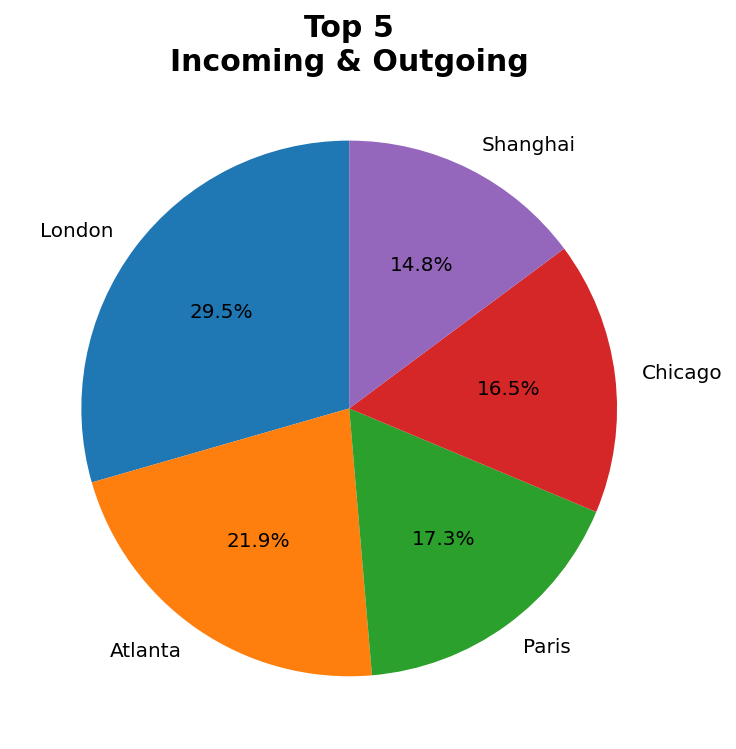

In [41]:
# visualize
warnings.filterwarnings(action='ignore')
cnum = sixth3_0_df['City'].count()
fig = plt.figure(figsize=(6,6))
plt.axis('equal')
set_matplotlib_formats('retina')
plt.pie(sixth3_0_df['Result'], labels=sixth3_0_df['City'],
       startangle=90, autopct='%1.1f%%')
plt.title(f'Top {cnum}\nIncoming & Outgoing', fontsize=15, fontweight='bold')
plt.show()

In [42]:
# given city
find6 = input("Enter City: ")
## incoming
# check execution time
start = time.time()
# highest tot num of incoming airline in city
sixth1_1 = spark.sql(f"SELECT airlines1.AirlineID, airlines1.Name, COUNT(routes1.AirlineID) as incoming \
    FROM routes1, airports1, airlines1, countries1 \
    WHERE countries1.Name = airports1.Country AND \
    routes1.DestinationAirportID = airports1.AirportID AND \
    airlines1.AirlineID = routes1.AirlineID AND \
    airports1.City LIKE '{find6}' \
    GROUP BY airlines1.AirlineID, airlines1.Name \
    ORDER BY incoming DESC \
    LIMIT 10")
sixth1_1.show()
print("execution time: ", time.time() - start)
sixth1_1.createOrReplaceTempView("sixth1_1")

## outgoing
# check execution time
start = time.time()
# highest tot num of outgoing airline in city
sixth1_2 = spark.sql(f"SELECT airlines1.AirlineID, airlines1.Name, COUNT(routes1.AirlineID) as outgoing \
    FROM routes1, airports1, airlines1, countries1 \
    WHERE countries1.Name = airports1.Country AND \
    routes1.SourceAirportID = airports1.AirportID AND \
    airlines1.AirlineID = routes1.AirlineID AND \
    airports1.City LIKE '{find6}' \
    GROUP BY airlines1.AirlineID, airlines1.Name \
    ORDER BY outgoing DESC \
    LIMIT 10")
sixth1_2.show()
print("execution time: ", time.time() - start)
sixth1_2.createOrReplaceTempView("sixth1_2")

## incoming + outgoing
# check execution time
start = time.time()
sixth3 = spark.sql(f"SELECT sixth1_1.AirlineID, sixth1_1.Name, (incoming + outgoing) as Result \
    FROM sixth1_1, sixth1_2 \
    WHERE sixth1_1.AirlineID = sixth1_2.AirlineID \
    ORDER BY Result DESC \
    LIMIT 10")
sixth3.show()
print("execution time: ", time.time() - start)



Enter City: London


+---------+--------------------+--------+
|AirlineID|                Name|incoming|
+---------+--------------------+--------+
|     1355|     British Airways|     194|
|     2297|             easyJet|     158|
|     4296|             Ryanair|     147|
|       24|   American Airlines|      98|
|     2822|     Iberia Airlines|      68|
|     8745|    Transavia France|      62|
|      220|         Air Bourbon|      37|
|     5347|Virgin Atlantic A...|      36|
|     2350|             Finnair|      31|
|     3737|Norwegian Air Shu...|      30|
+---------+--------------------+--------+

execution time:  2.0832650661468506
+---------+--------------------+--------+
|AirlineID|                Name|outgoing|
+---------+--------------------+--------+
|     1355|     British Airways|     193|
|     2297|             easyJet|     158|
|     4296|             Ryanair|     147|
|       24|   American Airlines|      97|
|     8745|    Transavia France|      70|
|     2822|     Iberia Airlines|      6

+---------+--------------------+------+
|AirlineID|                Name|Result|
+---------+--------------------+------+
|     1355|     British Airways|   387|
|     2297|             easyJet|   316|
|     4296|             Ryanair|   294|
|       24|   American Airlines|   195|
|     2822|     Iberia Airlines|   136|
|     8745|    Transavia France|   132|
|      220|         Air Bourbon|    74|
|     5347|Virgin Atlantic A...|    72|
|     2350|             Finnair|    61|
|     3737|Norwegian Air Shu...|    60|
+---------+--------------------+------+

execution time:  2.742072105407715


### Problem 7
#### Given two cities X and Y, provide a list of routes connecting cities X and Y.

Given: (two cities x,y)  
airports(City)

input:  
countries1(name)  
airlines1(AirlineID, Name, Country, IATA)  
airports1(Name,City,Country,AirportID, Timezone, IATA)  
routes1(AirlineID, DestinationAirportID,SourceAirportID)  
planes1(Name, IATA)
       
output: City1, City2, airports1(Name1), airports1(Name2), airlineID, airlines1(Name), planes1(Name), airports1(timezone1), airports1(timezone2)


In [43]:
# # given cities
# # departure
# find7_1 = input("Enter City (departure): ")
# # arrive
# find7_2 = input("Enter City (arrive): ")
# # check execution time
# start = time.time()
# # find routes
# seven1 = spark.sql(f"SELECT airport1.city, airport2.city, airport1.name, airport2.name, airlineID, airlines1.name, planes1.name\
#     FROM airport1 airports1, airport2 airports1, airlines1, routes1, planes1, countries1\
#     WHERE ")
# sixth1_1.show()
# print("execution time: ", time.time() - start)



### Problem 8
#### Given two cities X and Y and a number of stops Z, provide a list of routes connecting cities X and Y with less than Z stops

### Problem 9
#### Given a city X and number of stops Y, provide a list of cities that can be reached from X within Y stops.

### Problem 10
#### Given all routes, provide the transitive closure of the graph of all routes.

## Save Dataframe to Mongo

In [45]:
p1.select("AirportID", "Name", "City", "Country").write.format('com.mongodb.spark.sql.DefaultSource')\
    .option( "uri", "mongodb://127.0.0.1:27017/AirportsResult.Problem1") \
    .save()


In [46]:
p2.select("AirlineID", "Name", "Stops").write.format('com.mongodb.spark.sql.DefaultSource')\
    .option( "uri", "mongodb://127.0.0.1:27017/AirportsResult.Problem2") \
    .save()

In [47]:
p3.select("AirlineID", "Name", "Country", "Codeshare").write.format('com.mongodb.spark.sql.DefaultSource')\
    .option( "uri", "mongodb://127.0.0.1:27017/AirportsResult.Problem3") \
    .save()

In [48]:
p4.select("AirlineID", "Name", "Country", "Active").write.format('com.mongodb.spark.sql.DefaultSource')\
    .option( "uri", "mongodb://127.0.0.1:27017/AirportsResult.Problem4") \
    .save()

In [49]:
fifth.select("Country", "Result").write.format('com.mongodb.spark.sql.DefaultSource')\
     .option( "uri", "mongodb://127.0.0.1:27017/AirportsResult.Problem5") \
     .save()



In [50]:
sixth3.select("AirlineID", "Name", "Result").write.format('com.mongodb.spark.sql.DefaultSource')\
     .option( "uri", "mongodb://127.0.0.1:27017/AirportsResult.Problem6") \
     .save()